# Image segmentaion with masked facies

Squish rectangular images to square

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
#np.set_printoptions(threshold=sys.maxsize)

In [5]:
torch.cuda.set_device(0)

In [6]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: 704604a6, DATE: 20191215


In [7]:
UID='0d3edb45'
DATE='20191214'

In [8]:
SUBSET_DATA=False
SUBSET_LEN=171

In [9]:
tgt_height = 256
data_dir = Path('data')
train_images = data_dir/'train_images'
test_img = train_images/'mask_fill/test'

train_path = train_images/'mask_fill/train'
train_mask = train_path/'masks'
train_img = train_path/'images'


#subset
train_sub_path = train_images/'mask_fill/subset/train'
train_sub_mask = train_sub_path/'masks'
train_sub_img = train_sub_path/'images'

#train_path = train_sub_path
#train_mask = train_sub_mask
#train_img = train_sub_img


In [10]:
filename = 'data/CAX_LogFacies_Train_File.csv'

#### all data

In [11]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()
    
df_val = all_wells_df.sample(frac=0.2)
idx=df_val.index
df_trn=all_wells_df[~all_wells_df.index.isin(idx)]
assert len(df_val)+len(df_trn)==len(all_wells_df)
#df_val.to_csv(train_path/'val_20pct.csv', index=False, header=False)

In [12]:
df_val.tail()

,0
3916,well_3916.png
3253,well_3253.png
1614,well_1614.png
1069,well_1069.png
3758,well_3758.png


#### Subset

In [13]:
df_val = pd.read_csv(train_images/'mask_fill/train/val_20pct.csv', names=["well_id"])
ids=range(0,SUBSET_LEN)
well_names=[]
for i in ids:
    well_names.append('well_'+str(i)+'.png')
df_sub_val=df_val.loc[df_val['well_id'].isin(well_names)]
#df_sub_val.to_csv(train_sub_path/'val_sub_20pct.csv', index=False, header=False)

### Data

In [14]:
train_img_names = get_image_files(train_img)
len(train_img_names)

4000

In [15]:
train_img_names[:3]

[PosixPath('data/train_images/mask_fill/train/images/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/images/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/images/well_1321.png')]

In [16]:
for im in train_img_names:
    assert 'crop' not in str(im)

In [17]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('data/train_images/mask_fill/train/masks/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1321.png')]

In [18]:
for im in train_mask_names:
    assert 'crop' not in str(im)

#### Resize

If required

In [19]:
def resize_to(to_w, to_h, from_w, from_h, im_folder, postfix='_resized'):
    w_ratio = to_w/from_w
    h_ratio = to_h/from_h

    for infile in im_folder:
        name=str(infile).split('/')[-1].split('.png')[0]
        img = cv2.imread(str(infile), cv2.IMREAD_UNCHANGED) 
        width = int(img.shape[1] * w_ratio )
        height = int(img.shape[0] * h_ratio) 
        dim = (width, height) 
        #INTER_AREA introduces extra colours
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_NEAREST) 
        pim = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        im_pil = pil_image.fromarray(pim)
        im_pil.save(train_mask/f'{name}{postfix}.png')

In [20]:
#resize_to(1100, 275, 1528, 390, train_mask, postfix='_resized')

### Data QC

In [21]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [22]:
train_img_names[0]

PosixPath('data/train_images/mask_fill/train/images/well_2640.png')

In [23]:
missing_i_m=set(inames) - set(mnames)

In [24]:
missing_m_i= set(mnames)-set(inames) 

In [25]:
assert len(missing_i_m)==len(missing_m_i)==0

In [26]:
len(inames)

4000

In [27]:
len(mnames)

4000

In [28]:
inames.sort()
mnames.sort()

In [29]:
len(inames)

4000

In [30]:
for im,mm in zip(inames, mnames):
    assert im==mm
    img=train_img/f'{im}'
    mmg=train_mask/f'{mm}'
    img_ =pil_image.open(img)
    mmg_ =pil_image.open(mmg)
    if img_.size != mmg_.size:
        print(f'img_.size: {img_.size} != mmg_.size: {mmg_.size}')

data/train_images/mask_fill/train/images/well_1770.png


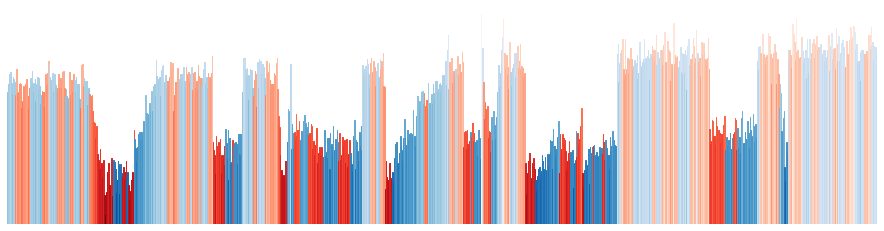

In [31]:
img_f = train_img_names[5]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

In [32]:
img_h, img_w=img_gr.size

In [33]:
img_w

1100

In [34]:
img_h

275

In [35]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file namez

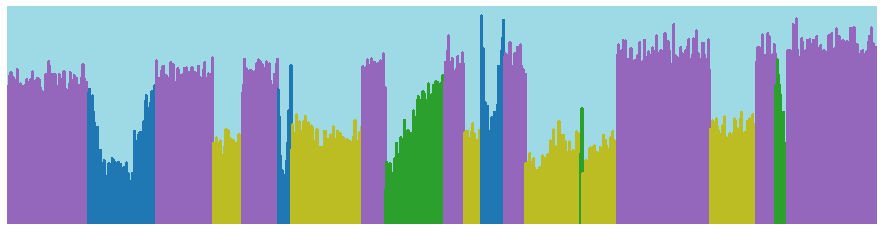

In [36]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [37]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 275, 1100]), tensor([[[5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          [5, 5, 5,  ..., 5, 5, 5],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [38]:
mask.data.shape

torch.Size([1, 275, 1100])

In [39]:
np.unique(mask.data.numpy())

array([0, 1, 2, 4, 5])

### Convert masks to n color values only

In [40]:
f_u_values=[]
def fai_get_all_uniques(images):
    for im in images:
        mask = open_mask(get_y_fn(im))
        f_u_values.extend(np.unique(mask.data.numpy().tolist()))
    return f_u_values

In [41]:
train_mask_names

[PosixPath('data/train_images/mask_fill/train/masks/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1321.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1001.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_2711.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1770.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_2758.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_674.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_605.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_3079.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_984.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_3031.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1303.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_51.png'),
 PosixPath('data/train_images/mask_fill

In [42]:
np.unique(np.asarray(pil_image.open(train_mask_names[0])))

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [68]:
def get_colours(images):
    for i, im in enumerate(images):
        img=pil_image.open(im)
        colors = img.convert('RGB').getcolors()
        print(colors)
        assert True==False

In [75]:
unique_pixels=[
    [255, 255, 255], 
    [255, 0, 0], 
    [153, 102, 51], 
    [255, 255, 0], 
    [0, 0, 255], 
    [0, 128, 0]]

In [76]:
c_pixels=[
    [0, 0, 0], 
    [1, 1, 1], 
    [2, 2, 2], 
    [3, 3, 3], 
    [4, 4, 4], 
    [5, 5, 5]]

In [71]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        print(mask.shape)
        #remove opcacity
        #a=mask[:,:,:-1]
        a=mask[:,:1,:-1]
        print(a.shape)
        #u_values.extend(np.unique(mask.tolist()))
        print(a)
        assert True==False
    return u_values

In [72]:
train_mask_mpl = train_path/'masks_with_mpl_colours'
train_mask_names_mpl = get_image_files(train_mask_mpl)
#get_colours(train_mask_names_mpl)
#u_values=list(set(get_all_uniques(train_mask_names_mpl, 100)))

In [66]:
#u_values=list(set(get_all_uniques(train_mask_names, 100)))
#u_values.sort()

In [77]:
#print(u_values)
#u_values=[0, 51, 102, 128, 153, 255]

In [118]:
def convert_masks_pixels(unique_pixels,unique_colours, images, save_path):
    print(f'>>convert_masks_pixels() colours: {len(u_values)} images: {len(images)} to {save_path}')
    for i, im in enumerate(images):
        mask = np.asarray(pil_image.open(im))
        mask_c=mask[:,:,:-1].copy()
        for p, c in zip(unique_pixels, unique_colours):
            mask_c[np.where((mask_c==p).all(axis=2))] = c
        #print(f'mask_c: {mask_c}')
        #print(f'mask: {mask}')
        #print(f'mask_c: {mask_c.shape}, mask: {mask.shape}')
        #assert True==False
        image = pil_image.fromarray(mask_c)
        name=im.name.split('.png')[0]
        image.save(save_path/f'{name}_replaced.png')

In [119]:
train_mask_mpl = train_path/'masks_with_mpl_colours'
train_mask_names_mpl = get_image_files(train_mask_mpl)
convert_masks_pixels(unique_pixels, c_pixels, train_mask_names_mpl, train_mask)

>>convert_masks_pixels() colours: 0 images: 4000 to data/train_images/mask_fill/train/masks


In [89]:
def convert_masks_format(u_values, images, save_path):
    """This function drps one of the coloours use convert_masks_pixels instead """
    for i, im in enumerate(images):
        mask = np.asarray(pil_image.open(im))
        mask_c=mask.copy()
        for i, c in enumerate(u_values):
            mask_c[mask_c == u_values[i]] = i
        image = pil_image.fromarray(mask_c)
        name=im.name.split('.png')[0]
        image.save(save_path/f'{name}_replaced.png')

In [43]:
def convert_imasks_fai_format(u_values, images, save_path):
    '''Opening masks using fastai, use convert_masks_pixels instead'''
    for im in images:
        A = open_mask(get_y_fn(im)).data.numpy()
        for i, c in enumerate(u_values):
            A[A == u_values[i]] = i
        image = pil_image.fromarray(A[0])
        name=im.name.split('.png')[0]
        image.save(save_path/f'{name}_fai.png')

### Link Masks with Images

In [34]:
get_y_fn(img_f)

PosixPath('data/train_images/mask_fill/train/masks/well_1770.png')

We need a custom mask function as fastai merges colours

see https://forums.fast.ai/t/u-net-rgb-masks-values-convertion-in-fast-ai/50672/3

In [35]:
def get_unique_colours(img_name):
    im = pil_image.open(img_name)
    by_color = defaultdict(int)
    for pixel in im.getdata():
        by_color[pixel] += 1
    return by_color

In [36]:
train_mask_names[4]

PosixPath('data/train_images/mask_fill/train/masks/well_2711.png')

In [37]:
get_unique_colours(train_mask_names[4])

defaultdict(int,
            {(255, 255, 255, 255): 105823,
             (153, 102, 51, 255): 124938,
             (0, 128, 0, 255): 15883,
             (255, 0, 0, 255): 19901,
             (0, 0, 255, 255): 20347,
             (255, 255, 0, 255): 15608})

Create a list of RGB values in order of idx value to replace with, i.e. 0: [0,0,0], 1: [255,0,0]

Note we have an extra colour for background (where GR is > log value but less than absolute GR cutoff)

We use RGB not RGBA

In [38]:
facies_rgb_list = [
    [255, 255, 255],
    [153, 102, 51],
    [0, 128, 0],
    [255, 0, 0],
    [0, 0, 255],
    [255, 255, 0]]

In [39]:
def div_rgbs(rgb_list):
    rgb_zero_one=[]
    for l in rgb_list:
        rgb_zero_one.append([i /255 for i in l])
    return rgb_zero_one

In [40]:
def convert_mask(old_mask, rgb_list, div):
    '''
    create a bytemask for pixels = rgb value to be replaced, 
    sum over all columns
    fill in pixels with new idx value
    '''
    new_mask = torch.zeros((old_mask.shape[-2],old_mask.shape[-1]))
    for idx, rgb in enumerate(rgb_list):
        rgb_mask = torch.sum(old_mask.data.view((3,-1)).permute(1,0) == tensor(rgb),dim=1)==3 
        new_mask.masked_fill_(rgb_mask.view(new_mask.shape), tensor(idx)) 
    if div: 
        new_mask.div_(255)
    print(f'max: {torch.max(new_mask)}, div: {div}')
    return ImageSegment(new_mask.unsqueeze(0))

def open_mask_converted(fn:PathOrStr, div, convert_mode='RGB', after_open:Callable=None, rgb_list=facies_rgb_list)->ImageSegment:
    '''Note we apply div after opening and conversion'''
    return convert_mask(open_image(fn, div=False, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open), rgb_list, div=div)

need to override SegmentationLabelList to use unique color masks

In [41]:
class UniqueSegmentationLabelList(ImageList):
    "ItemList for segmentation masks"
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        print(f'>>UniqueSegmentationLabelList.__init__() classes: {classes}')
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)
        
    def open(self, fn): 
        #need to use div=true so is betwween 0 and 1
        print('>>UniqueSegmentationLabelList.open()')
        return open_mask_converted(fn, div=True)
        #return open_mask(fn)
    def analyze_pred(self, pred, thresh:float=0.5): 
        return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): 
        return ImageSegment(t)

class UniqueSegmentationItemList(ImageList):
    _label_cls,_square_show_res = SegmentationLabelList,False

In [42]:
class BasicSegmentationLabelList(SegmentationLabelList):
    def open(self, fn): 
        assert True==False
        return open_mask_converted(fn, div=True)

class BasicSegmentationItemList(SegmentationItemList):
    _label_cls,_square_show_res = SegmentationLabelList,False

In [43]:
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

In [44]:
mask = open_mask_converted(get_y_fn(img_f), convert_mode='RGB', div=False)

max: 5.0, div: False


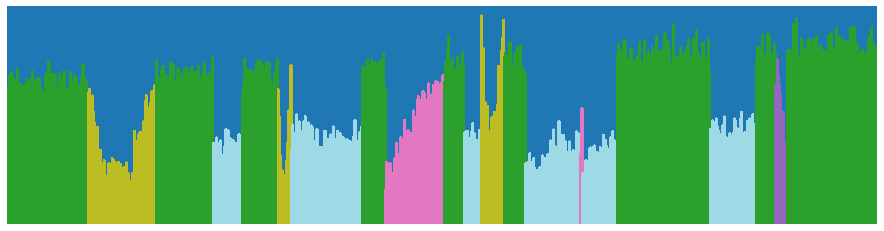

In [45]:
#mask = open_mask(get_y_fn(img_f)) # fastai shows masks with distinct colors 
# or open_mask(get_y_fn(img_f))  # mask reads file as (bs,x,y) so bs=1 here
# mask also assigns ints to floats >

#Return ImageSegment object create from mask in file fn. If div, divides pixel values by 255.
mask.show(figsize=(18,4), alpha=1)

In [46]:
type(mask)

fastai.vision.image.ImageSegment

Compare to facies generated in matplotlib

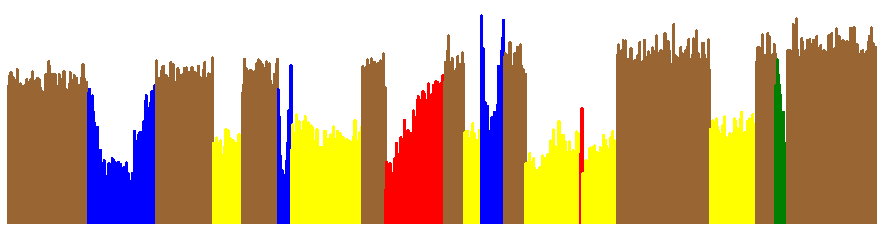

In [47]:
img_m = get_y_fn(img_f)
img = open_image(img_m)
img.show(figsize=(18,4))

### Log Facies

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [48]:
codes = array(['Background', 'None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'])

In [49]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 275, 1100]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

In [50]:
gr_size = np.array(img_gr.shape[1:])
gr_size,img_gr.data

(array([ 275, 1100]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.5843, 0.6392, 0.6980,  ..., 0.7961, 0.8235, 0.8000],
          [0.5843, 0.6392, 0.6980,  ..., 0.7961, 0.8235, 0.8000],
          [0.5843, 0.6392, 0.6980,  ..., 0.7961, 0.8235, 0.8000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7725, 0.8000, 0.8235,  ..., 0.8706, 0.8902, 0.8745],
          [0.7725, 0.8000, 0.8235,  ..., 0.8706, 0.8902, 0.8745],
          [0.7725, 0.8000, 0.8235,  ..., 0.8706, 0.8902, 0.8745]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000,

<pre>
Need data layout:
    data/
        images/
        labels/ #masks - for camvid same name as image but with _P postfix (before .png)
        codes.txt #text with each label on sep line
</pre>

In [51]:
train_img

PosixPath('data/train_images/mask_fill/train/images')

In [52]:
df_val=pd.read_csv(train_path/'val_20pct.csv', header=None)

In [53]:
df_val.head()

,0
0,well_87.png
1,well_154.png
2,well_3917.png
3,well_444.png
4,well_875.png


In [54]:
len(df_val)

800

## Datasets

In [55]:
bs = 16
#size=src_size//2
#squish to square

size=(tgt_height, tgt_height)

In [56]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1.1, max_lighting=0.0, \
                    max_warp=0., p_affine=0., p_lighting=0.0)

In [57]:
if SUBSET_DATA:
    #when SegmentationLabelList is overridden, need to pass in classes early
    src = (SegItemListCustom.from_folder(train_img)
       .split_by_fname_file('../val_sub_20pct.csv')
       .label_from_func(get_y_fn, classes=codes))
else:
    src = (SegItemListCustom.from_folder(train_img)
       .split_by_fname_file('../val_20pct.csv', path=train_img)
       #.split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [58]:
train_img

PosixPath('data/train_images/mask_fill/train/images')

In [59]:
len(src.train.x)

3200

In [60]:
type(src.train.x)

__main__.SegItemListCustom

<pre>
SegmentationItemList->ImageList->ItemList
ItemList.__getitem__

ImageDataBunch->DataBunch
DataBunch.dl = DeviceDataLoader
</pre>

In [61]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [62]:
data.train_ds.x[0].shape

torch.Size([3, 275, 1100])

In [63]:
data.train_ds.y[0].shape

torch.Size([1, 275, 1100])

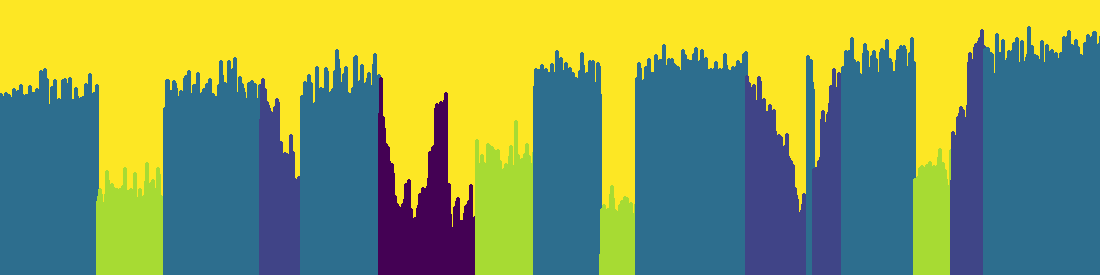

In [64]:
data.train_ds.y[0]

In [65]:
data.label_list

LabelLists;

Train: LabelList (3200 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/train_images/mask_fill/train/images;

Valid: LabelList (800 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/train_images/mask_fill/train/images;

Test: None

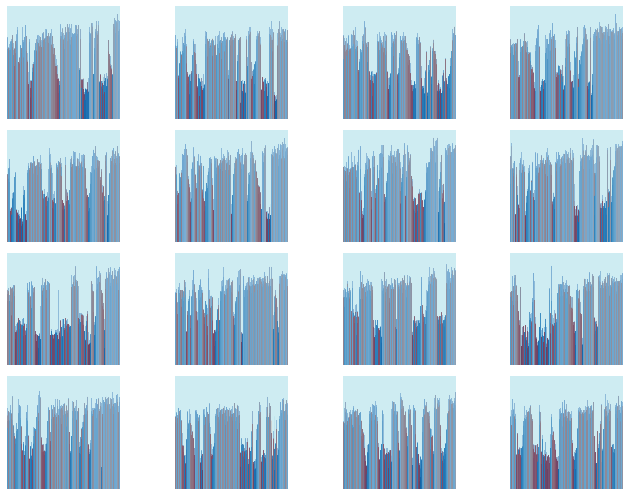

In [66]:
data.show_batch(4, figsize=(10,7))

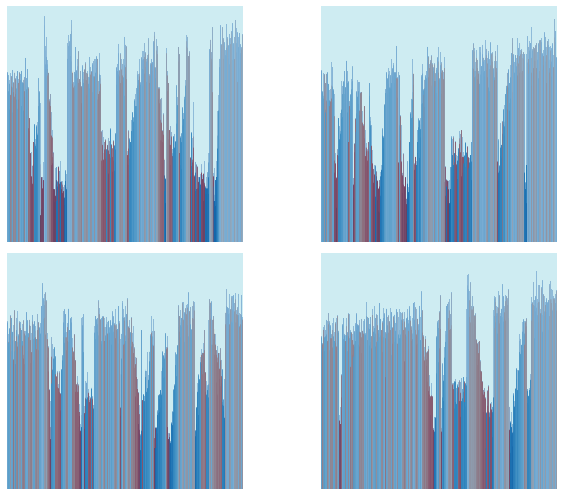

In [67]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [68]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [69]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_camvid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [70]:
data

ImageDataBunch;

Train: LabelList (3200 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/train_images/mask_fill/train/images;

Valid: LabelList (800 items)
x: SegItemListCustom
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegLabelListCustom
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: data/train_images/mask_fill/train/images;

Test: None

In [71]:
wd=1e-2

In [72]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()

In [73]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [74]:
#learn.loss_func=dice
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [75]:
learn.pred_batch()

tensor([[[[0.1663, 0.1821, 0.2187,  ..., 0.2591, 0.2724, 0.2225],
          [0.1920, 0.2206, 0.2711,  ..., 0.2817, 0.2936, 0.2270],
          [0.1827, 0.2201, 0.2588,  ..., 0.1624, 0.1712, 0.1437],
          ...,
          [0.1424, 0.1378, 0.1671,  ..., 0.1114, 0.1606, 0.2255],
          [0.1630, 0.1478, 0.1986,  ..., 0.0963, 0.1173, 0.1797],
          [0.1999, 0.1577, 0.1866,  ..., 0.1109, 0.1558, 0.1794]],

         [[0.0822, 0.0363, 0.0171,  ..., 0.0206, 0.0183, 0.0211],
          [0.0952, 0.0287, 0.0114,  ..., 0.0128, 0.0105, 0.0196],
          [0.0765, 0.0328, 0.0228,  ..., 0.0075, 0.0078, 0.0164],
          ...,
          [0.0581, 0.0242, 0.0190,  ..., 0.0276, 0.0220, 0.0226],
          [0.0828, 0.0459, 0.0224,  ..., 0.0508, 0.0294, 0.0340],
          [0.0727, 0.0663, 0.0253,  ..., 0.0697, 0.0544, 0.0581]],

         [[0.1466, 0.1123, 0.0780,  ..., 0.1366, 0.0975, 0.1280],
          [0.1197, 0.0760, 0.0686,  ..., 0.1197, 0.0616, 0.1177],
          [0.1762, 0.0975, 0.1749,  ..., 0

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


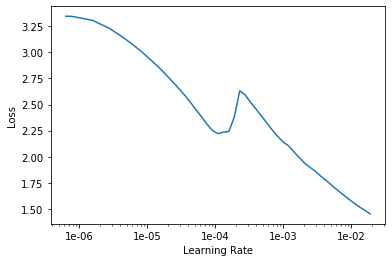

In [77]:
learn.recorder.plot()

In [78]:
lr=1e-3

In [79]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.068179,0.049848,0.987047,01:00
1,0.046175,0.044683,0.983618,01:00
2,0.042211,0.042783,0.995993,01:00
3,0.039725,0.039842,0.993091,01:00
4,0.037212,0.039172,0.989538,01:00


In [80]:
learn.data.classes

array(['Background', 'None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'], dtype='<U11')

In [81]:
interp=SegmentationInterpretation.from_learner(learn)

In [82]:
top_losses, top_idxs=interp.top_losses((128,128))

In [83]:
top_losses, top_idxs

(tensor([0.1253, 0.1102, 0.0897,  ..., 0.0181, 0.0176, 0.0162]),
 tensor([ 584, 2447, 3056,  ...,  424,  280, 2922]))

In [84]:
top_losses.shape

torch.Size([3200])

In [85]:
top_idxs.shape

torch.Size([3200])

tensor(0.0472)


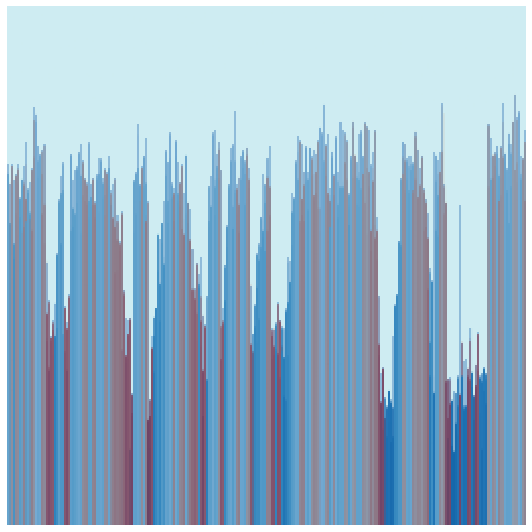

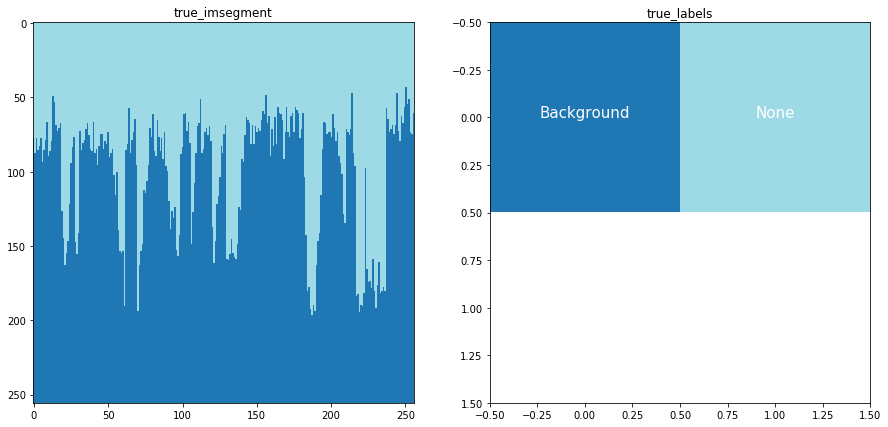

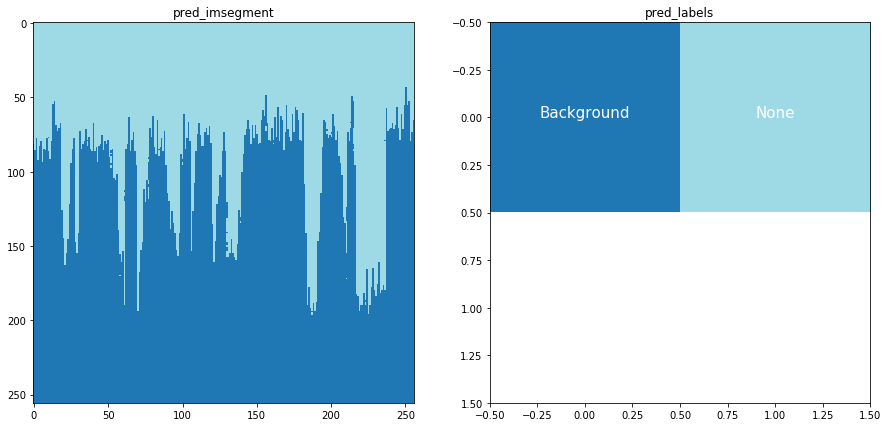

In [86]:
# show top loss
print(top_losses[top_idxs[0]])
interp.show_xyz(top_idxs[0], codes, sz=15)

(array([ 13., 206., 638., 780., 655., 443., 225., 131.,  60.,  28.,   8.,   5.,   4.,   2.,   0.,   0.,   0.,   1.,
          0.,   1.]),
 array([0.016158, 0.021616, 0.027074, 0.032532, 0.03799 , 0.043448, 0.048906, 0.054364, 0.059822, 0.06528 , 0.070738,
        0.076196, 0.081654, 0.087112, 0.09257 , 0.098028, 0.103486, 0.108944, 0.114403, 0.119861, 0.125319],
       dtype=float32),
 <a list of 20 Patch objects>)

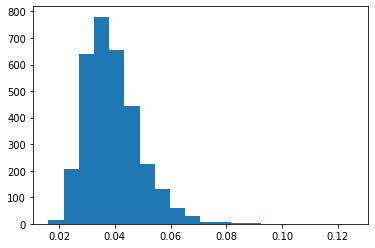

In [87]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [88]:
# top loss idxs of images
top_idxs[:5]

tensor([ 584, 2447, 3056,  281, 1577])

In [89]:
mean_cm, single_img_cm = interp._generate_confusion()

In [90]:
mean_cm.shape, single_img_cm.shape

((6, 6), (800, 6, 6))

label,score
None,0.989502
Background,0.982402
Symmetrical,NaN
Cylindrical,NaN
Funnel,NaN
Bell,NaN


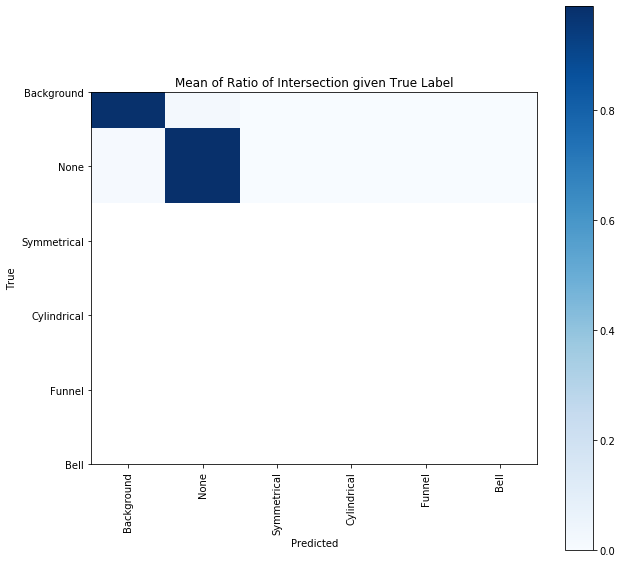

In [91]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
None,0.99164
Background,0.98272
Symmetrical,NaN
Cylindrical,NaN
Funnel,NaN
Bell,NaN


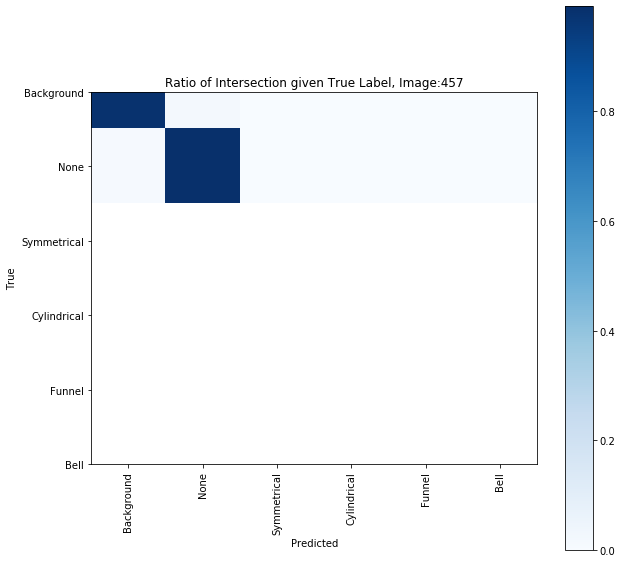

In [92]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

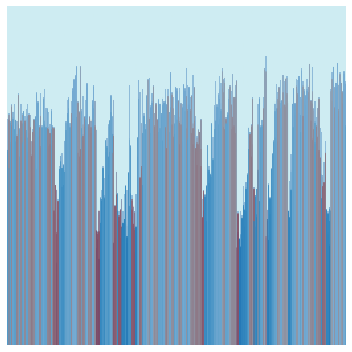

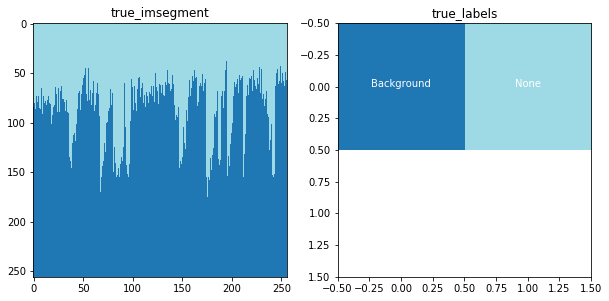

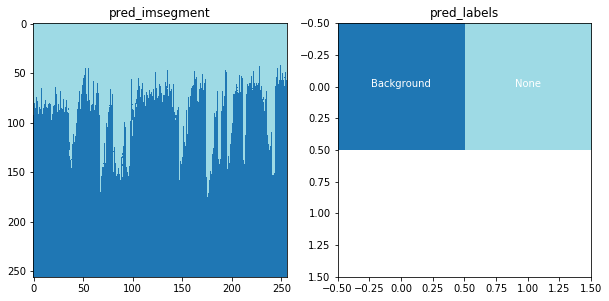

In [93]:
# show xyz
interp.show_xyz(i)

In [ ]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
# Fit one cycle of 12 epochs
lr = 1e-4
learn.fit_one_cycle(5, slice(lr/5, lr))

In [ ]:
learn.save(f'01_03-{UID}_unet_squish-s2-r0-{DATE}')

In [ ]:
learn=learn.to_fp32()

In [ ]:
learn.export(f'01_03-{UID}_unet_squish-s2-r0-{DATE}.pkl')

In [ ]:
print(f'01_03-{UID}_unet_squish-s2-r0-{DATE}')

### Inference

In [91]:
#learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()
test_data = SegmentationItemList.from_folder(test_img)


In [93]:
learn = load_learner(path=train_img, file='01_03-0d3edb45_unet_squish-s2-r0-20191214.pkl', test=test_data)

Exception: It's not possible to apply those transforms to your dataset:
 Not implemented: you can't apply transforms to this type of item (EmptyLabel)

In [ ]:
learn = load_learner(path, fname=..., test=test_data)

In [83]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

AttributeError: 'NoneType' object has no attribute 'dataset'

In [ ]:
# Generate rle encodings (images are first converted to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [ ]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

In [ ]:
sub_df.to_csv('submission.csv', index=False)